In [2]:
#import qqespm_module2 as qq2
#import qqspm_sql_module3 as qqsql3
#import qqspm_elastic_module3 as qqelastic3
#import qqsimple_module as qqsimple
from itertools import chain
import requests
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
import random
import numpy as np
import pandas as pd
from lat_lon_distance2 import lat_lon_distance as distance
from ilquadtree import ILQuadTree
import ilquadtree
import shapely
import geojson
geojson.geometry.DEFAULT_PRECISION = 6
from copy import deepcopy
import json
import pickle
import gc
from time import time, sleep
#from psycopg2.extensions import ISOLATION_LEVEL_AUTOCOMMIT
requests.packages.urllib3.disable_warnings()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from functools import partial
import multiprocessing
from multiprocessing.pool import ThreadPool
from remote_ilquadtree import remote_ilquadtree
import seaborn as sns
import matplotlib
import qqespm_quadtree_CGA as qq2

In [3]:
executions = pd.read_csv('executions_comparison_london_new2.csv', names = ['repetition', 'sp_index', 'spatial_pattern', 'number_of_vertices', 
        'number_of_edges', 'number_of_exclusions', 'qualitative_prob', 'dataset_size', 'module', 'total_solutions', 'elapsed_time', 'memory_usage'], index_col=False)
print('Total executions:', executions.shape[0])
executions.head()

Total executions: 5040


,repetition,sp_index,spatial_pattern,number_of_vertices,number_of_edges,number_of_exclusions,qualitative_prob,dataset_size,module,total_solutions,elapsed_time,memory_usage
0,1,0,"{""vertices"": [{""id"": 0, ""keyword"": ""theatre""},...",2,1,0,1.0,7600,qq_quadtree_alternated,0,0.001411,190.730469
1,1,0,"{""vertices"": [{""id"": 0, ""keyword"": ""theatre""},...",2,1,0,1.0,7600,qq_quadtree_min,0,0.001544,191.730469
2,1,0,"{""vertices"": [{""id"": 0, ""keyword"": ""theatre""},...",2,1,0,1.0,7600,qq_quadtree_old,0,0.001387,192.621094
3,1,0,"{""vertices"": [{""id"": 0, ""keyword"": ""theatre""},...",2,1,0,1.0,7600,qq_simple,0,0.034848,194.210938
4,1,0,"{""vertices"": [{""id"": 0, ""keyword"": ""theatre""},...",2,1,0,1.0,7600,qq_elastic,0,0.299806,32909.062500


In [4]:
executions[executions['module']=='qq_quadtree_alternated']['elapsed_time'].describe()

count    720.000000
mean       0.245689
std        2.711165
min        0.000648
25%        0.005383
50%        0.009030
75%        0.019500
max       62.673238
Name: elapsed_time, dtype: float64

In [5]:
executions[executions['module']=='qq_quadtree_min']['elapsed_time'].describe()

count    720.000000
mean       0.302107
std        3.586284
min        0.000879
25%        0.005161
50%        0.008206
75%        0.017852
max       67.292374
Name: elapsed_time, dtype: float64

In [6]:
executions[executions['module']=='qq_quadtree_old']['elapsed_time'].describe()

count     720.000000
mean        6.935877
std       128.807305
min         0.000900
25%         0.005275
50%         0.008396
75%         0.018463
max      3330.095072
Name: elapsed_time, dtype: float64

In [7]:
executions[executions['module']=='qq_simple']['elapsed_time'].describe()

count     720.000000
mean       12.815442
std       142.290969
min         0.010890
25%         0.045762
50%         0.086459
75%         0.325874
max      3345.203090
Name: elapsed_time, dtype: float64

In [8]:
executions[executions['module']=='qq_elastic']['elapsed_time'].describe()

count    720.000000
mean       0.335511
std        2.675196
min        0.044530
25%        0.069858
50%        0.093835
75%        0.152656
max       62.595501
Name: elapsed_time, dtype: float64

In [9]:
executions[executions['module']=='qq_sql_implicit']['elapsed_time'].describe()

count    720.000000
mean       1.694080
std       23.925173
min        0.034396
25%        0.039986
50%        0.042984
75%        0.333778
max      589.969000
Name: elapsed_time, dtype: float64

In [10]:
executions[executions['module']=='qq_sql_explicit']['elapsed_time'].describe()

count    720.000000
mean       0.244812
std        0.595737
min        0.035230
25%        0.042490
50%        0.051461
75%        0.359866
max       12.316843
Name: elapsed_time, dtype: float64

In [13]:
executions_100perc = executions[executions['dataset_size']==38000]
executions_100perc.shape

(1008, 12)

In [11]:
executions.loc[executions['module']=='qq_quadtree_alternated', 'module'] = 'QQESPM-Quadtree CGA'
executions.loc[executions['module']=='qq_quadtree_min', 'module'] = 'QQESPM-Quadtree CGM'
executions.loc[executions['module']=='qq_quadtree_old', 'module'] = 'QQESPM-Quadtree NoC'
executions.loc[executions['module']=='qq_simple', 'module'] = 'ESPM+TV'
executions.loc[executions['module']=='qq_elastic', 'module'] = 'QQESPM-Elastic'
executions.loc[executions['module']=='qq_sql_implicit', 'module'] = 'QQESPM-SQL Imp'
executions.loc[executions['module']=='qq_sql_explicit', 'module'] = 'QQESPM-SQL Exp'

executions['module'].value_counts()

module
QQESPM-Quadtree CGA    720
QQESPM-Quadtree CGM    720
QQESPM-Quadtree NoC    720
ESPM+TV                720
QQESPM-Elastic         720
QQESPM-SQL Imp         720
QQESPM-SQL Exp         720
Name: count, dtype: int64

In [5]:
executions_summarized = executions.groupby(['sp_index', 'dataset_size', 'module', 'spatial_pattern', 'number_of_vertices', 
        'number_of_edges', 'number_of_exclusions', 'qualitative_prob', 'total_solutions'], as_index=False)[['elapsed_time', 'memory_usage']].mean()

In [9]:
executions = executions_summarized
executions.shape

(1920, 11)

In [5]:
executions['dataset_size'].value_counts()

dataset_size
7600     192
15200    192
22800    192
30400    192
38000    192
Name: count, dtype: int64

In [64]:
executions['module'].value_counts()

module
QQESPM-Quadtree CGA    720
QQESPM-Quadtree CGM    720
QQESPM-Quadtree NoC    720
ESPM+TV                720
QQESPM-Elastic         720
QQESPM-SQL Imp         720
QQESPM-SQL Exp         720
Name: count, dtype: int64

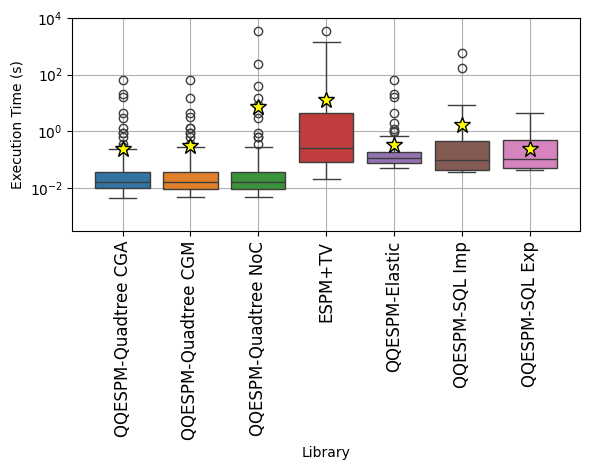

In [14]:
fig, ax = plt.subplots()
fig.set_figwidth(6)
ax.set_yscale('log', base=10)
ax.set_ylim(3*10**(-4), 10**4)


sns.boxplot(data = executions_100perc, y="elapsed_time", x = 'module', hue = 'module', ax = ax, showmeans=False, meanprops={'marker':'^',
                       'markerfacecolor':'white', 
                       'markeredgecolor':'black',
                       'markersize':'8'}, order=['QQESPM-Quadtree CGA', 'QQESPM-Quadtree CGM', 'QQESPM-Quadtree NoC', 
                                                 'ESPM+TV', 'QQESPM-Elastic', 'QQESPM-SQL Imp', 'QQESPM-SQL Exp'])
ax.set_xlabel('Library')
ax.set_ylabel('Execution Time (s)')

ax.set_xticklabels(['QQESPM-Quadtree CGA', 'QQESPM-Quadtree CGM', 'QQESPM-Quadtree NoC', 
                                                 'ESPM+TV', 'QQESPM-Elastic', 'QQESPM-SQL Imp', 'QQESPM-SQL Exp'], fontsize=12, rotation=90)

ax.plot(0, executions[executions.module=='QQESPM-Quadtree CGA']['elapsed_time'].mean(),
             color='yellow', marker='*', markeredgecolor='k', markersize=12)
ax.plot(1, executions[executions.module=='QQESPM-Quadtree CGM']['elapsed_time'].mean(),
             color='yellow', marker='*', markeredgecolor='k', markersize=12)
ax.plot(2, executions[executions.module=='QQESPM-Quadtree NoC']['elapsed_time'].mean(),
             color='yellow', marker='*', markeredgecolor='k', markersize=12)
ax.plot(3, executions[executions.module=='ESPM+TV']['elapsed_time'].mean(),
             color='yellow', marker='*', markeredgecolor='k', markersize=12)
ax.plot(4, executions[executions.module=='QQESPM-Elastic']['elapsed_time'].mean(),
             color='yellow', marker='*', markeredgecolor='k', markersize=12)
ax.plot(5, executions[executions.module=='QQESPM-SQL Imp']['elapsed_time'].mean(),
             color='yellow', marker='*', markeredgecolor='k', markersize=12)
ax.plot(6, executions[executions.module=='QQESPM-SQL Exp']['elapsed_time'].mean(),
             color='yellow', marker='*', markeredgecolor='k', markersize=12)


plt.grid()
plt.tight_layout()
fig.savefig('out.png', bbox_inches='tight', pad_inches=0.05)
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

In [18]:
executions['dataset_size'].value_counts().index.tolist()

[7600, 15200, 22800, 30400, 38000]

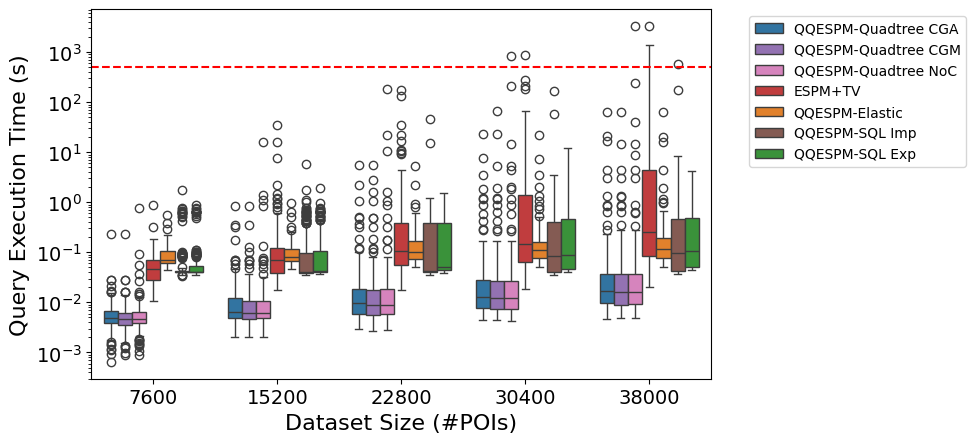

In [40]:
module_to_colors = {"QQESPM-Quadtree CGA": "tab:blue", 
                    "QQESPM-Quadtree CGM": "tab:purple", 
                    "QQESPM-Quadtree NoC": "tab:pink",
                    "ESPM+TV": "tab:red",
                    "QQESPM-Elastic": "tab:orange",
                    "QQESPM-SQL Imp": "tab:brown",
                    "QQESPM-SQL Exp": "tab:green",
                    }

palette = [module_to_colors[libr] for libr in executions['module'].values]

fig, ax = plt.subplots()
fig.set_figwidth(8)

ax.set_yscale('log', base=10)
#ax.set_ylim(3*10**(-4), 10**4)
#estimator=(lambda e: np.percentile(e, [90])[0]), 
sns.boxplot(data=executions, x="dataset_size", y="elapsed_time", hue="module", palette=palette)#, errorbar=None, lw=4)#estimator='mean', 
ax.set_xticklabels(executions['dataset_size'].value_counts().index.tolist(), fontsize=14, rotation=0)
ax.set_yticklabels(ax.get_yticks(), fontsize=14)
ax.yaxis.set_major_formatter(matplotlib.ticker.LogFormatterMathtext())
ax.set_xlabel('Dataset Size (#POIs)', fontsize=16, )
ax.set_ylabel('Query Execution Time (s)', fontsize=16, )
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


plt.axhline(y = 500, color = 'r', linestyle = 'dashed')   

In [141]:
def extract_keywords(spatial_pattern_dict):
    keywords = []
    for v in spatial_pattern_dict['vertices']:
        keywords.append(v['keyword'])
    return keywords

executions['keywords'] = executions['spatial_pattern'].apply(json.loads).apply(extract_keywords)

In [3]:
pois = qq2.read_df_csv(data_dir = 'london_pois_5500_40perc.csv')
pois.shape

(15200, 10)

In [4]:
frequent_keywords = list(set().union(
    set(pois['amenity'].value_counts().head(25).to_dict().items()),
    set(pois['shop'].value_counts().head(25).to_dict().items()),
    set(pois['tourism'].value_counts().head(25).to_dict().items()),
    set(pois['landuse'].value_counts().head(25).to_dict().items()),
    set(pois['leisure'].value_counts().head(25).to_dict().items()),
    set(pois['building'].value_counts().head(25).to_dict().items()),
))

In [312]:
set(executions[executions['total_solutions']>100000]['spatial_pattern'].values.tolist())

{'{"vertices": [{"id": 0, "keyword": "post_office"}, {"id": 1, "keyword": "doityourself"}, {"id": 2, "keyword": "doctors"}, {"id": 3, "keyword": "sports"}, {"id": 4, "keyword": "drinking_water"}], "edges": [{"id": 0, "vi": 0, "vj": 1, "lij": 173.79170552395053, "uij": 1627.0442647132277, "sign": ">", "relation": null}, {"id": 1, "vi": 1, "vj": 2, "lij": 599.4219417007657, "uij": 2183.4944771825562, "sign": "-", "relation": null}, {"id": 2, "vi": 2, "vj": 3, "lij": 213.1829332909526, "uij": 1651.1998195765868, "sign": "<", "relation": null}, {"id": 3, "vi": 3, "vj": 1, "lij": 466.09975926348625, "uij": 1451.3590982188234, "sign": "-", "relation": "disjoint"}, {"id": 4, "vi": 3, "vj": 4, "lij": 205.58597704044445, "uij": 1790.4096129388688, "sign": "<>", "relation": null}]}',
 '{"vertices": [{"id": 0, "keyword": "toys"}, {"id": 1, "keyword": "bag"}, {"id": 2, "keyword": "retail"}, {"id": 3, "keyword": "hostel"}], "edges": [{"id": 0, "vi": 0, "vj": 1, "lij": 1.118862958816469, "uij": 485.

In [46]:
executions_quadtree = executions[executions['module']=='QQESPM-Quadtree']
executions_elastic = executions[executions['module']=='QQESPM-Elastic']
executions_sql = executions[executions['module']=='QQESPM-SQL']

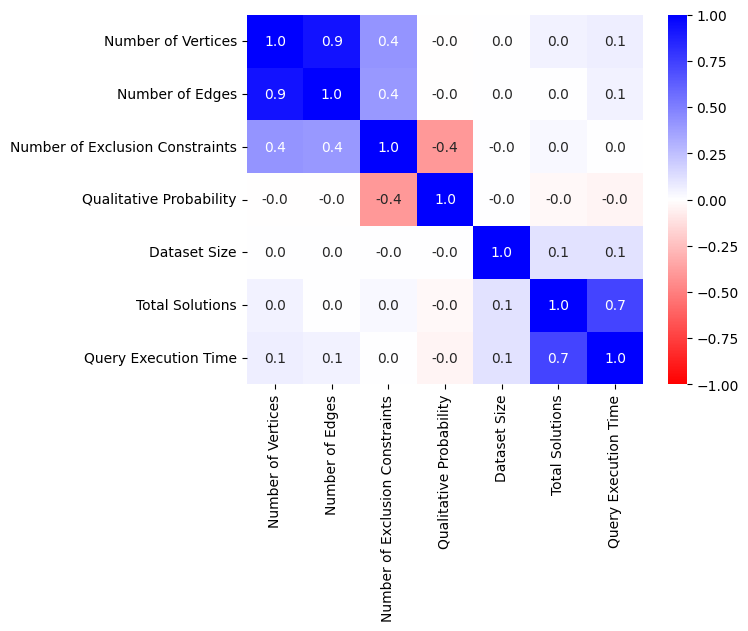

In [47]:
conf_matrix = executions_quadtree[['number_of_vertices', 'number_of_edges', 'number_of_exclusions', 'qualitative_prob', 'dataset_size', 'total_solutions', 'elapsed_time']].corr()#[['elapsed_time']]
conf_matrix.index = ['Number of Vertices', 'Number of Edges', 'Number of Exclusion Constraints', 'Qualitative Probability', 'Dataset Size', 'Total Solutions', 'Query Execution Time']
conf_matrix.rename(columns={
    'elapsed_time': 'Query Execution Time',
    'number_of_vertices': 'Number of Vertices',
    'number_of_edges': 'Number of Edges',
    'number_of_exclusions': 'Number of Exclusion Constraints',
    'qualitative_prob': 'Qualitative Probability',
    'dataset_size': 'Dataset Size',
    'total_solutions': 'Total Solutions'
    }, inplace=True)
# conf_matrix.rename(columns={'elapsed_time': 'Correlation with Query Execution Time',
#                             'number_of_vertices': 'Number of Vertices',
#                             'number_of_edges': 'Number of Edges', 
#                             'number_of_exclusions': 'Number of Exclusion Constraints', 
#                             'qualitative_prob': 'Qualitative Probability', 
#                             'total_solutions': 'Total Solutions'}, inplace=True)
ax = sns.heatmap(conf_matrix, annot=True, fmt=".1f", vmin=-1, vmax=1, cmap = matplotlib.colormaps['bwr_r'])
#ax.set_title('Influence of Search Metrics on Execution Time for QQESPM-Quadtree')
# sns.dark_palette("#69d", reverse=True, as_cmap=True)
# sns.light_palette("tab:blue", as_cmap=True)

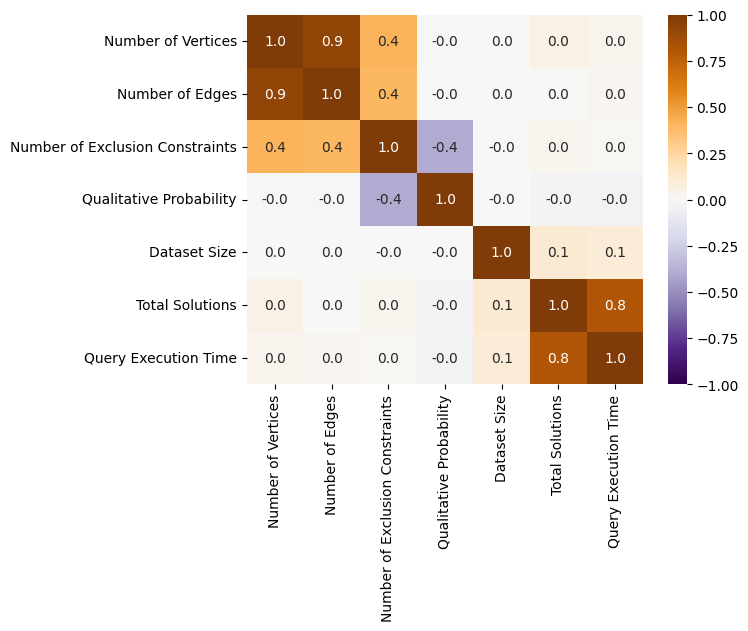

In [48]:
conf_matrix = executions_elastic[['number_of_vertices', 'number_of_edges', 'number_of_exclusions', 'qualitative_prob', 'dataset_size', 'total_solutions', 'elapsed_time']].corr()#[['elapsed_time']]
conf_matrix.index = ['Number of Vertices', 'Number of Edges', 'Number of Exclusion Constraints', 'Qualitative Probability', 'Dataset Size', 'Total Solutions', 'Query Execution Time']
conf_matrix.rename(columns={
    'elapsed_time': 'Query Execution Time',
    'number_of_vertices': 'Number of Vertices',
    'number_of_edges': 'Number of Edges',
    'number_of_exclusions': 'Number of Exclusion Constraints',
    'qualitative_prob': 'Qualitative Probability',
    'dataset_size': 'Dataset Size',
    'total_solutions': 'Total Solutions'
    }, inplace=True)
# conf_matrix.rename(columns={'elapsed_time': 'Correlation with Query Execution Time',
#                             'number_of_vertices': 'Number of Vertices',
#                             'number_of_edges': 'Number of Edges', 
#                             'number_of_exclusions': 'Number of Exclusion Constraints', 
#                             'qualitative_prob': 'Qualitative Probability', 
#                             'total_solutions': 'Total Solutions'}, inplace=True)
ax = sns.heatmap(conf_matrix, annot=True, fmt=".1f", vmin=-1, vmax=1, cmap = matplotlib.colormaps['PuOr_r'])
#ax.set_title('Influence of Search Metrics on Execution Time for QQESPM-Elastic')

In [119]:
from matplotlib import colormaps
list(colormaps)

['magma',
 'inferno',
 'plasma',
 'viridis',
 'cividis',
 'twilight',
 'twilight_shifted',
 'turbo',
 'Blues',
 'BrBG',
 'BuGn',
 'BuPu',
 'CMRmap',
 'GnBu',
 'Greens',
 'Greys',
 'OrRd',
 'Oranges',
 'PRGn',
 'PiYG',
 'PuBu',
 'PuBuGn',
 'PuOr',
 'PuRd',
 'Purples',
 'RdBu',
 'RdGy',
 'RdPu',
 'RdYlBu',
 'RdYlGn',
 'Reds',
 'Spectral',
 'Wistia',
 'YlGn',
 'YlGnBu',
 'YlOrBr',
 'YlOrRd',
 'afmhot',
 'autumn',
 'binary',
 'bone',
 'brg',
 'bwr',
 'cool',
 'coolwarm',
 'copper',
 'cubehelix',
 'flag',
 'gist_earth',
 'gist_gray',
 'gist_heat',
 'gist_ncar',
 'gist_rainbow',
 'gist_stern',
 'gist_yarg',
 'gnuplot',
 'gnuplot2',
 'gray',
 'hot',
 'hsv',
 'jet',
 'nipy_spectral',
 'ocean',
 'pink',
 'prism',
 'rainbow',
 'seismic',
 'spring',
 'summer',
 'terrain',
 'winter',
 'Accent',
 'Dark2',
 'Paired',
 'Pastel1',
 'Pastel2',
 'Set1',
 'Set2',
 'Set3',
 'tab10',
 'tab20',
 'tab20b',
 'tab20c',
 'magma_r',
 'inferno_r',
 'plasma_r',
 'viridis_r',
 'cividis_r',
 'twilight_r',
 'twilight

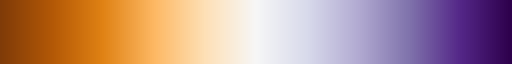

In [120]:
matplotlib.colormaps['PuOr']

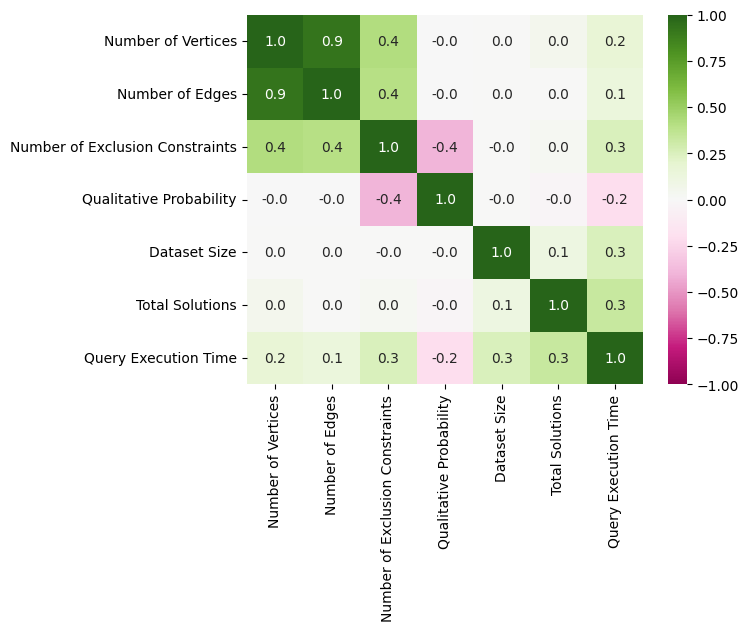

In [49]:
conf_matrix = executions_sql[['number_of_vertices', 'number_of_edges', 'number_of_exclusions', 'qualitative_prob', 'dataset_size', 'total_solutions', 'elapsed_time']].corr()#[['elapsed_time']]
conf_matrix.index = ['Number of Vertices', 'Number of Edges', 'Number of Exclusion Constraints', 'Qualitative Probability', 'Dataset Size', 'Total Solutions', 'Query Execution Time']
conf_matrix.rename(columns={
    'elapsed_time': 'Query Execution Time',
    'number_of_vertices': 'Number of Vertices',
    'number_of_edges': 'Number of Edges',
    'number_of_exclusions': 'Number of Exclusion Constraints',
    'qualitative_prob': 'Qualitative Probability',
    'dataset_size': 'Dataset Size',
    'total_solutions': 'Total Solutions'
    }, inplace=True)
# conf_matrix.rename(columns={'elapsed_time': 'Correlation with Query Execution Time',
#                             'number_of_vertices': 'Number of Vertices',
#                             'number_of_edges': 'Number of Edges', 
#                             'number_of_exclusions': 'Number of Exclusion Constraints', 
#                             'qualitative_prob': 'Qualitative Probability', 
#                             'total_solutions': 'Total Solutions'}, inplace=True)
ax = sns.heatmap(conf_matrix, annot=True, fmt=".1f", vmin=-1, vmax=1, cmap = matplotlib.colormaps['PiYG'])
#ax.set_title('Influence of Search Metrics on Execution Time for QQESPM-SQL')
#sns.dark_palette("tab:green", reverse=True, as_cmap=True)

In [52]:
executions_1e = executions_100perc[executions_100perc['number_of_edges']==1]
executions_2e = executions_100perc[executions_100perc['number_of_edges']==2]
executions_3e = executions_100perc[executions_100perc['number_of_edges']==3]
executions_4e = executions_100perc[executions_100perc['number_of_edges']==4]
executions_5e = executions_100perc[executions_100perc['number_of_edges']==5]

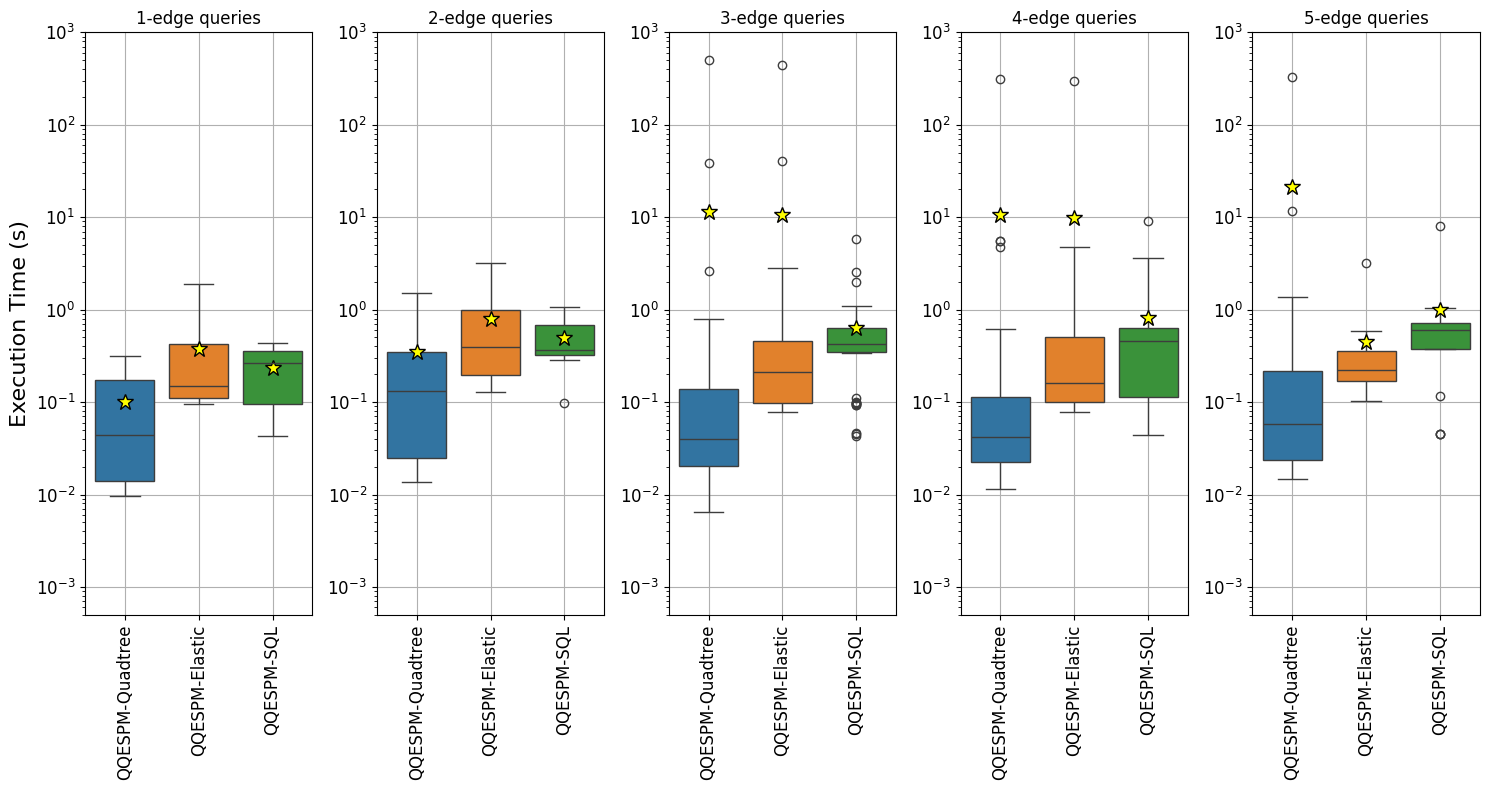

In [53]:
fig, (ax1e, ax2e, ax3e, ax4e, ax5e) = plt.subplots(1, 5)
fig.set_figwidth(15)
fig.set_figheight(8)

ax1e.set_yscale('log', base=10)
ax2e.set_yscale('log', base=10)
ax3e.set_yscale('log', base=10)
ax4e.set_yscale('log', base=10)
ax5e.set_yscale('log', base=10)

ax1e.set_ylim(5*10**(-4), 10**3)
ax2e.set_ylim(5*10**(-4), 10**3)
ax3e.set_ylim(5*10**(-4), 10**3)
ax4e.set_ylim(5*10**(-4), 10**3)
ax5e.set_ylim(5*10**(-4), 10**3)

palette = [module_to_colors[libr] for libr in executions_1e['module'].values]
ax1e.set_title('1-edge queries')
sns.boxplot(data = executions_1e, y="elapsed_time", x = 'module', hue='module', ax = ax1e, showmeans=False, meanprops={'marker':'^',
                       'markerfacecolor':'white', 
                       'markeredgecolor':'black',
                       'markersize':'8'}, order=['QQESPM-Quadtree', 'QQESPM-Elastic', 'QQESPM-SQL'], palette=palette)
ax1e.set_xticklabels(['QQESPM-Quadtree', 'QQESPM-Elastic', 'QQESPM-SQL'], fontsize=12, rotation=90)
ax1e.set_yticklabels(ax1e.get_yticks(), fontsize=12)
ax1e.yaxis.set_major_formatter(matplotlib.ticker.LogFormatterMathtext())
#ax1e.set_yscale('log', base=10)
ax1e.set_xlabel('')
ax1e.grid()
ax1e.set_ylabel('Execution Time (s)', fontsize=16)
#Plot the means
ax1e.plot(0, executions_1e[executions_1e.module=='QQESPM-Quadtree']['elapsed_time'].mean(),
             color='yellow', marker='*', markeredgecolor='k', markersize=12)
ax1e.plot(1, executions_1e[executions_1e.module=='QQESPM-Elastic']['elapsed_time'].mean(),
             color='yellow', marker='*', markeredgecolor='k', markersize=12)
ax1e.plot(2, executions_1e[executions_1e.module=='QQESPM-SQL']['elapsed_time'].mean(),
             color='yellow', marker='*', markeredgecolor='k', markersize=12)


palette = [module_to_colors[libr] for libr in executions_2e['module'].values]
ax2e.set_title('2-edge queries')
sns.boxplot(data = executions_2e, y="elapsed_time", x = 'module', hue='module', ax = ax2e, showmeans=False, meanprops={'marker':'^',
                       'markerfacecolor':'white', 
                       'markeredgecolor':'black',
                       'markersize':'8'}, order=['QQESPM-Quadtree', 'QQESPM-Elastic', 'QQESPM-SQL'], palette=palette)
ax2e.set_xticklabels(['QQESPM-Quadtree', 'QQESPM-Elastic', 'QQESPM-SQL'], fontsize=12, rotation=90)
ax2e.set_yticklabels(ax2e.get_yticks(), fontsize=12)
ax2e.yaxis.set_major_formatter(matplotlib.ticker.LogFormatterMathtext())
#ax2e.set_yscale('log', base=10)
ax2e.set_xlabel('')
ax2e.grid()
ax2e.set_ylabel('', fontsize=16)
#Plot the means
ax2e.plot(0, executions_2e[executions_2e.module=='QQESPM-Quadtree']['elapsed_time'].mean(),
             color='yellow', marker='*', markeredgecolor='k', markersize=12)
ax2e.plot(1, executions_2e[executions_2e.module=='QQESPM-Elastic']['elapsed_time'].mean(),
             color='yellow', marker='*', markeredgecolor='k', markersize=12)
ax2e.plot(2, executions_2e[executions_2e.module=='QQESPM-SQL']['elapsed_time'].mean(),
             color='yellow', marker='*', markeredgecolor='k', markersize=12)


palette = [module_to_colors[libr] for libr in executions_3e['module'].values]
ax3e.set_title('3-edge queries')
sns.boxplot(data = executions_3e, y="elapsed_time", x = 'module', hue='module', ax = ax3e, showmeans=False, meanprops={'marker':'^',
                       'markerfacecolor':'white', 
                       'markeredgecolor':'black',
                       'markersize':'8'}, order=['QQESPM-Quadtree', 'QQESPM-Elastic', 'QQESPM-SQL'], palette=palette)
ax3e.set_xticklabels(['QQESPM-Quadtree', 'QQESPM-Elastic', 'QQESPM-SQL'], fontsize=12, rotation=90)
ax3e.set_yticklabels(ax3e.get_yticks(), fontsize=12)
ax3e.yaxis.set_major_formatter(matplotlib.ticker.LogFormatterMathtext())
#ax3e.set_yscale('log', base=10)
ax3e.set_xlabel('')
ax3e.grid()
ax3e.set_ylabel('', fontsize=16)
#Plot the means
ax3e.plot(0, executions_3e[executions_3e.module=='QQESPM-Quadtree']['elapsed_time'].mean(),
             color='yellow', marker='*', markeredgecolor='k', markersize=12)
ax3e.plot(1, executions_3e[executions_3e.module=='QQESPM-Elastic']['elapsed_time'].mean(),
             color='yellow', marker='*', markeredgecolor='k', markersize=12)
ax3e.plot(2, executions_3e[executions_3e.module=='QQESPM-SQL']['elapsed_time'].mean(),
             color='yellow', marker='*', markeredgecolor='k', markersize=12)


palette = [module_to_colors[libr] for libr in executions_4e['module'].values]
ax4e.set_title('4-edge queries')
sns.boxplot(data = executions_4e, y="elapsed_time", x = 'module', hue='module', ax = ax4e, showmeans=False, meanprops={'marker':'^',
                       'markerfacecolor':'white', 
                       'markeredgecolor':'black',
                       'markersize':'8'}, order=['QQESPM-Quadtree', 'QQESPM-Elastic', 'QQESPM-SQL'], palette=palette)
ax4e.set_xticklabels(['QQESPM-Quadtree', 'QQESPM-Elastic', 'QQESPM-SQL'], fontsize=12, rotation=90)
ax4e.set_yticklabels(ax4e.get_yticks(), fontsize=12)
ax4e.yaxis.set_major_formatter(matplotlib.ticker.LogFormatterMathtext())
#ax4e.set_yscale('log', base=10)
ax4e.set_xlabel('')
ax4e.grid()
ax4e.set_ylabel('', fontsize=16)
#Plot the means
ax4e.plot(0, executions_4e[executions_4e.module=='QQESPM-Quadtree']['elapsed_time'].mean(),
             color='yellow', marker='*', markeredgecolor='k', markersize=12)
ax4e.plot(1, executions_4e[executions_4e.module=='QQESPM-Elastic']['elapsed_time'].mean(),
             color='yellow', marker='*', markeredgecolor='k', markersize=12)
ax4e.plot(2, executions_4e[executions_4e.module=='QQESPM-SQL']['elapsed_time'].mean(),
             color='yellow', marker='*', markeredgecolor='k', markersize=12)


palette = [module_to_colors[libr] for libr in executions_5e['module'].values]
ax5e.set_title('5-edge queries')
sns.boxplot(data = executions_5e, y="elapsed_time", x = 'module', hue='module', ax = ax5e, showmeans=False, meanprops={'marker':'^',
                       'markerfacecolor':'white', 
                       'markeredgecolor':'black',
                       'markersize':'8'}, order=['QQESPM-Quadtree', 'QQESPM-Elastic', 'QQESPM-SQL'], palette=palette)
ax5e.set_xticklabels(['QQESPM-Quadtree', 'QQESPM-Elastic', 'QQESPM-SQL'], fontsize=12, rotation=90)
ax5e.set_yticklabels(ax5e.get_yticks(), fontsize=12)
ax5e.yaxis.set_major_formatter(matplotlib.ticker.LogFormatterMathtext())
#ax5e.set_yscale('log', base=10)
ax5e.set_xlabel('')
ax5e.grid()
ax5e.set_ylabel('', fontsize=16)
#Plot the means
ax5e.plot(0, executions_5e[executions_5e.module=='QQESPM-Quadtree']['elapsed_time'].mean(),
             color='yellow', marker='*', markeredgecolor='k', markersize=12)
ax5e.plot(1, executions_5e[executions_5e.module=='QQESPM-Elastic']['elapsed_time'].mean(),
             color='yellow', marker='*', markeredgecolor='k', markersize=12)
ax5e.plot(2, executions_5e[executions_5e.module=='QQESPM-SQL']['elapsed_time'].mean(),
             color='yellow', marker='*', markeredgecolor='k', markersize=12)

#fig.suptitle('Execution Time by Total Edges in the Search Pattern', fontsize=20)
plt.tight_layout()
plt.show()

# Memory Usage Assessment

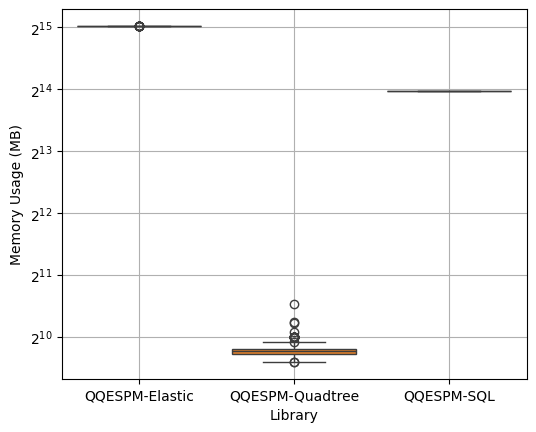

In [58]:
fig, ax = plt.subplots()
fig.set_figwidth(6)
ax.set_yscale('log', base=2)
#ax.set_ylim(3*10**(-4), 10**3)


sns.boxplot(data = executions, y="memory_usage", x = 'module', hue = 'module', ax = ax, showmeans=False, meanprops={'marker':'^',
                       'markerfacecolor':'white', 
                       'markeredgecolor':'black',
                       'markersize':'8'})
ax.set_xlabel('Library')
ax.set_ylabel('Memory Usage (MB)')

plt.grid()
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')